In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from ogb.utils.url import download_url, extract_zip
from matplotlib import pyplot as plt
import tarfile
from rdkit.Chem.AllChem import GetAdjacencyMatrix, RemoveHs

from molecules.physics import get_self_euclidean_dist_matrix
from molecules.parse_sdf import sdf_to_mols
from molecules.parse_cxsmiles import get_contact_dict, cxsmiles_to_mol_with_contact, try_read_cxsmiles

# WARNING: You need at least 120GB of RAM to read this file and execute the code
print("WARNING: You need at least 120GB of RAM to execute the code for the full dataset")

In [2]:
ROOT = "."
SDF_URL = "http://ogb-data.stanford.edu/data/lsc/pcqm4m-v2-train.sdf.tar.gz"
SDF_LOCAL = f"{ROOT}/pcqm4m-v2-train.sdf"
SDF_LOCAL_ZIP = f"{SDF_LOCAL}.tar.gz"
RAW_URL = "http://ogb-data.stanford.edu/data/lsc/pcqm4m-v2.zip"
RAW_CSV = f"{ROOT}/pcqm4m-v2/raw/data.csv.gz"
SKIP_DOWNLOAD = False # Set to false for downloading and unzipping the file. If already downloaded, set to True
OUT_PATH = "pcqm4m-contact.tsv.gz"

In [3]:
ANGSTROM_DIST_TH = 3.5
PATH_LEN_TH = 5
MAX_MOLS = None

In [4]:
if not SKIP_DOWNLOAD:
    # This can take many minutes
    path = download_url(SDF_URL, ROOT)
    if os.path.exists(SDF_LOCAL):
        print(f"Using existing file {SDF_LOCAL}")
    else:
        with tarfile.open(path) as file:
            file.extractall()

Using exist file pcqm4m-v2-train.sdf.tar.gz
Using existing file ./pcqm4m-v2-train.sdf


In [5]:
if not SKIP_DOWNLOAD:
    raw_path = download_url(RAW_URL, ROOT)
    extract_zip(raw_path, ROOT)

Using exist file pcqm4m-v2.zip
Extracting ./pcqm4m-v2.zip


 57%|█████▋    | 1921223/3378606 [08:49<06:19, 3842.38it/s]RDKit WARNING: [00:09:08] Conflicting single bond directions around double bond at index 12.
RDKit WARNING: [00:09:08]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 3378606/3378606 [14:52<00:00, 3786.99it/s]

3378606


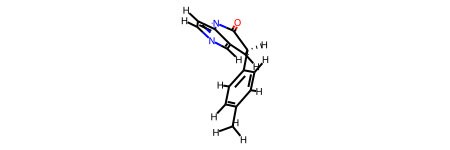

In [6]:
mols = sdf_to_mols(SDF_LOCAL, max_mols=MAX_MOLS, removeHs=False)
print(len(mols))
mols[0]

In [7]:
all_contact_dict = Parallel(n_jobs=-1)(delayed(get_contact_dict)(
    mol, angstrom_dist_threshold=ANGSTROM_DIST_TH, path_len_threshold=PATH_LEN_TH
    ) for mol in tqdm(mols))

# these_mols = mols[150000:]
# all_contact_dict = []
# for mol in tqdm(these_mols):
#     all_contact_dict.append(get_contact_dict(
#         mol, angstrom_dist_threshold=ANGSTROM_DIST_TH, path_len_threshold=PATH_LEN_TH
#     ))

100%|██████████| 3378606/3378606 [12:09<00:00, 4630.24it/s]


In [8]:
def validate_contact_maps(all_contact_dict, idx):
    # Validate visually that, when reading the cxsmiles, the contact map gives the right information
    contact_dict = all_contact_dict[idx]
    cxsmiles = contact_dict["cxsmiles"]
    mol, contact_idx = cxsmiles_to_mol_with_contact(cxsmiles)
    xyz = mol.GetConformer(0).GetPositions()
    dist_matrix = get_self_euclidean_dist_matrix(xyz[:, 0], xyz[:, 1], xyz[:, 2])
    dist_matrix[np.tril_indices_from(dist_matrix)] = float("nan")
    plt.imshow(dist_matrix)
    adj = GetAdjacencyMatrix(mol).astype(float)
    adj_4 = (np.linalg.matrix_power(adj, 4) + np.linalg.matrix_power(adj, 3) + np.linalg.matrix_power(adj, 2) + adj) > 0
    adj[contact_idx[:, 0], contact_idx[:, 1]] = 2
    adj[np.tril_indices_from(dist_matrix)] = float("nan")
    dist_matrix_inv = (dist_matrix ** -2)
    dist_matrix_inv[adj_4] = 0

    plt.subplot(1, 2, 1)
    plt.imshow(adj, vmin=0, vmax=2)
    plt.subplot(1, 2, 2)
    plt.imshow(dist_matrix_inv, vmin=0, vmax=ANGSTROM_DIST_TH**-2)
    plt.show()

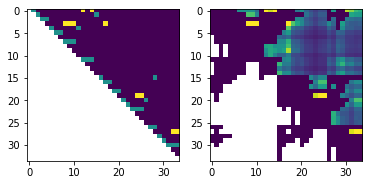

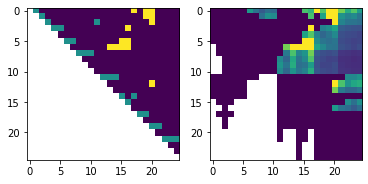

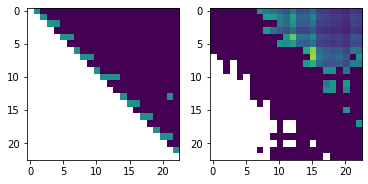

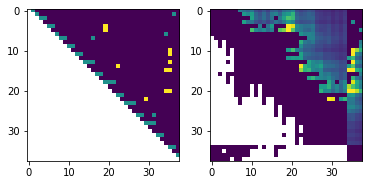

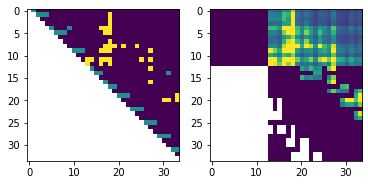

In [9]:
validate_contact_maps(all_contact_dict, 1)
validate_contact_maps(all_contact_dict, 13)
validate_contact_maps(all_contact_dict, 14)
validate_contact_maps(all_contact_dict, 333)
validate_contact_maps(all_contact_dict, 26017)

In [10]:
all_contact_dict[0].keys()

dict_keys(['num_atoms', 'adj', 'is_contact', 'idx_contact', 'num_contact', '3d_dist_contact', 'path_len_contact', 'cxsmiles', 'smiles'])

In [11]:
all_cxsmiles = [cxs["cxsmiles"] for cxs in all_contact_dict]
df = pd.DataFrame({"cxsmiles": all_cxsmiles})
df.to_csv(OUT_PATH, sep="\t", index=False)

In [12]:
# Make sure that `cxsmiles_to_mol_with_contact` works well on all molecules
test_df = pd.read_csv(OUT_PATH, sep="\t")
graph_contacts = Parallel(n_jobs=-1)(delayed(try_read_cxsmiles)(
    cxs, ii
    ) for ii, cxs in tqdm(enumerate(test_df["cxsmiles"])))

print("DONE! :)")

3378606it [07:45, 7253.59it/s] 


DONE! :)


num graph nodes 30
num atoms no Hs 18
num atoms 30


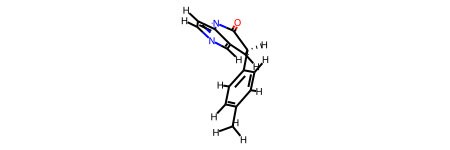

In [13]:
print("num graph nodes", graph_contacts[0]["num_nodes"])
print("num atoms no Hs", RemoveHs(mols[0]).GetNumAtoms())
print("num atoms", mols[0].GetNumAtoms())
mols[0]